In [1]:
import json
import math
import os

import cv2
import shutil
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm

%matplotlib inline

ImportError: cannot import name 'ImageDataGenerator' from 'keras.preprocessing.image' (C:\Users\gargg\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\preprocessing\image\__init__.py)

In [2]:
np.random.seed(2019)
tf.set_random_seed(2019)

In [3]:
os.makedirs('/kaggle/working/aptos-equal/train_images')

In [4]:
file_path = f'/kaggle/input/aptos2019-blindness-detection/train.csv'
data = pd.read_csv(file_path)

dict = {}
LABEL_SIZE = 193

for i in data.index:
    dict[data['id_code'][i]] = data['diagnosis'][i]

count = [0, 0, 0, 0, 0]
rows = []

for i in data.index:
    source_file_path = f'/kaggle/input/aptos2019-blindness-detection/train_images/'+data['id_code'][i]+'.png'
    destination_file_path = f'/kaggle/working/aptos-equal/train_images/'
    if count[data['diagnosis'][i]]<LABEL_SIZE and os.path.exists(source_file_path):
        rows.append([data['id_code'][i], data['diagnosis'][i]])
        shutil.copy(source_file_path, destination_file_path)
        count[data['diagnosis'][i]]+=1

columns = ['id_code', 'diagnosis']

df = pd.DataFrame(rows, columns=columns)

file_path = f'/kaggle/working/aptos-equal/train.csv'
df.to_csv(file_path, index=False)

In [5]:
df1 = pd.read_csv(f'/kaggle/working/aptos-equal/train.csv')
df1.shape

(965, 2)

In [6]:
datagen = ImageDataGenerator(
        zoom_range=0.15, 
        fill_mode='constant',
        cval=0.,  
        horizontal_flip=True,  
        vertical_flip=True,)

In [7]:
os.makedirs('/kaggle/working/aptos-equal/aug_images')

In [8]:
for j in range(df1.shape[0]):
    id_code = df1['id_code'][j]
    diagnosis = str(df1['diagnosis'][j])
    img = load_img(f'/kaggle/working/aptos-equal/train_images/{id_code}.png') 
    x = img_to_array(img)
    x = x.reshape((1, ) + x.shape) 
    
    i = 0
    for batch in datagen.flow(x, batch_size = 1, save_to_dir ='/kaggle/working/aptos-equal/aug_images', save_prefix = diagnosis + '_', save_format ='png'):
        i += 1
        if i > 5:
            break

In [10]:
augmented_rows = []
aug_dir = '/kaggle/working/aptos-equal/aug_images'

for augmented_img_name in os.listdir(aug_dir):
    augmented_rows.append([augmented_img_name, int(augmented_img_name[0])])

columns = ['id_code', 'diagnosis']
df_augmented = pd.DataFrame(augmented_rows, columns=columns)
output_csv_path = '/kaggle/working/aptos-equal/aug.csv'
df_augmented.to_csv(output_csv_path, index=False)

In [11]:
train_df = pd.read_csv('/kaggle/working/aptos-equal/aug.csv')
print(train_df.shape)
train_df.head()

(5466, 2)


,id_code,diagnosis
0,2__0_9574.png,2
1,1__0_2963.png,1
2,0__0_1964.png,0
3,0__0_21.png,0
4,0__0_2659.png,0


2    1102
1    1098
3    1095
0    1089
4    1082
Name: diagnosis, dtype: int64

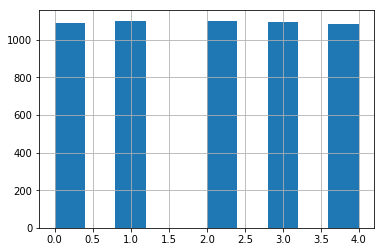

In [12]:
train_df['diagnosis'].hist()
train_df['diagnosis'].value_counts()

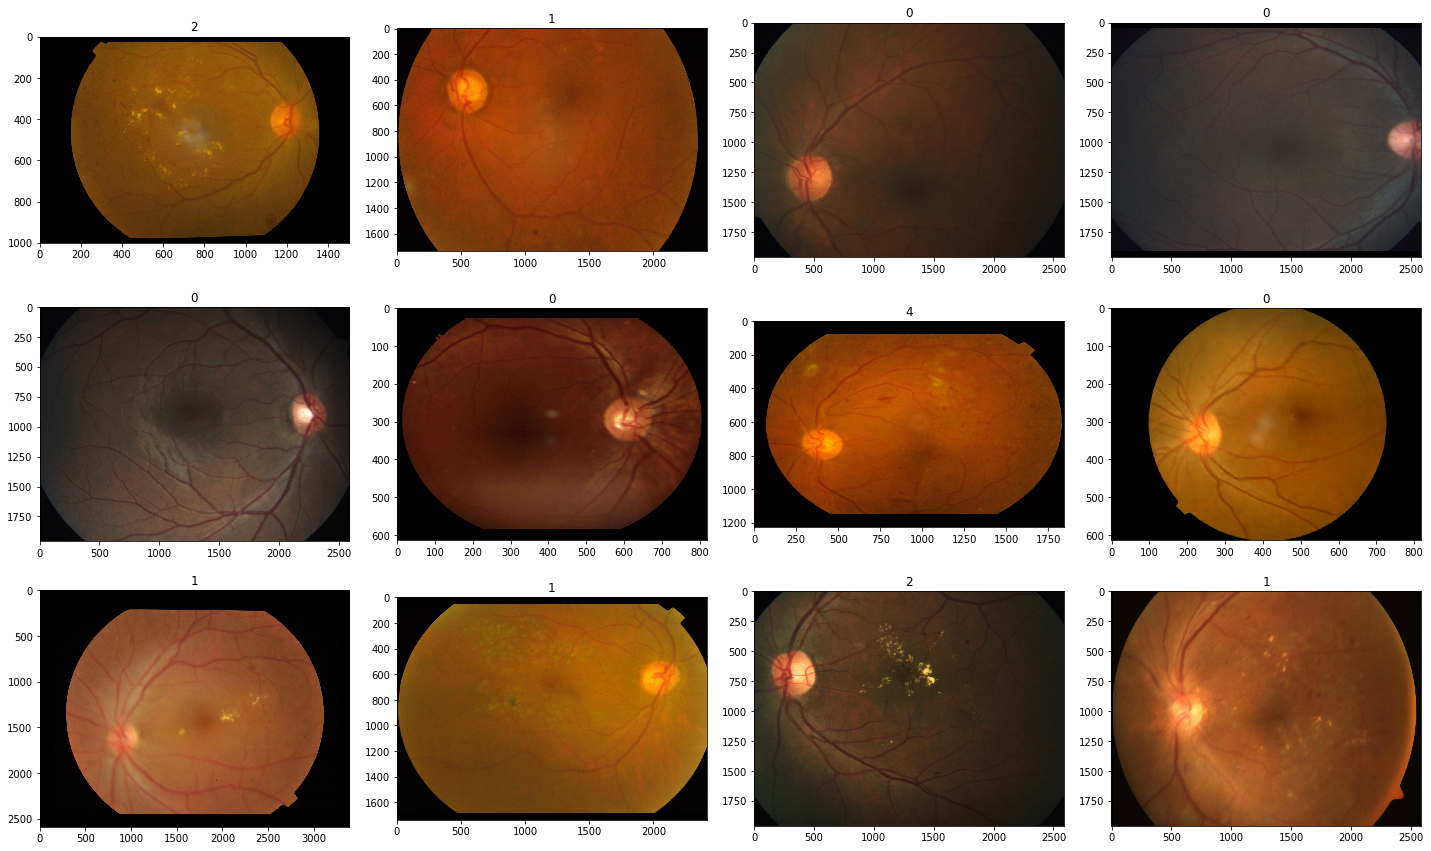

In [13]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'/kaggle/working/aptos-equal/aug_images/{image_path}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

In [14]:
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return im

In [15]:
N = train_df.shape[0]
x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
        f'/kaggle/working/aptos-equal/aug_images/{image_id}'
    )

100%|██████████| 5466/5466 [17:02<00:00,  4.83it/s]


In [16]:
y_train = pd.get_dummies(train_df['diagnosis']).values

print(x_train.shape)
print(y_train.shape)

(5466, 224, 224, 3)
(5466, 5)


In [17]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1089 1098 1102 1095 1082]
Multilabel version: [5466 4377 3279 2177 1082]


In [18]:
y_train_multi = y_train_multi[:x_train.shape[0]]

x_train_full, x_test, y_train_full, y_test = train_test_split(
    x_train, y_train_multi, 
    test_size=0.2,
    random_state=2019
)

x_train_partial, x_val, y_train_partial, y_val = train_test_split(
    x_train_full, y_train_full, 
    test_size=0.1, 
    random_state=2019
)

In [19]:
BATCH_SIZE = 32

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15, 
        fill_mode='constant',
        cval=0.,  
        horizontal_flip=True,  
        vertical_flip=True,  
    )

data_generator = create_datagen().flow(x_train_partial, y_train_partial, batch_size=BATCH_SIZE, seed=2019)

In [20]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

In [21]:
densenet = DenseNet121(
    weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

In [22]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [23]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


In [24]:
kappa_metrics = Metrics()

history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[kappa_metrics]
)

Epoch 1/10
171/170 [==============================] - 91s 530ms/step - loss: 0.3220 - acc: 0.8592 - val_loss: 0.2097 - val_acc: 0.9132
val_kappa: 0.8292
Validation Kappa has improved. Saving model.
Epoch 2/10
171/170 [==============================] - 52s 306ms/step - loss: 0.1887 - acc: 0.9207 - val_loss: 0.1945 - val_acc: 0.9269
val_kappa: 0.8565
Validation Kappa has improved. Saving model.
Epoch 3/10
171/170 [==============================] - 54s 315ms/step - loss: 0.1416 - acc: 0.9435 - val_loss: 0.1303 - val_acc: 0.9443
val_kappa: 0.8939
Validation Kappa has improved. Saving model.
Epoch 4/10
171/170 [==============================] - 53s 313ms/step - loss: 0.1046 - acc: 0.9601 - val_loss: 0.0881 - val_acc: 0.9699
val_kappa: 0.9551
Validation Kappa has improved. Saving model.
Epoch 5/10
171/170 [==============================] - 54s 316ms/step - loss: 0.0709 - acc: 0.9745 - val_loss: 0.0598 - val_acc: 0.9763
val_kappa: 0.9630
Validation Kappa has improved. Saving model.
Epoch 6/10

In [ ]:
model.save('densenet.keras')

In [25]:
y_pred = model.predict(x_test) > 0.5
y_pred = y_pred.astype(int).sum(axis=1) - 1
y_pred[0]

0

In [26]:
y_true = y_test.sum(axis=1) - 1
y_true[0]

0

In [27]:
print(y_pred.shape)
print(y_true.shape)

(1094,)
(1094,)


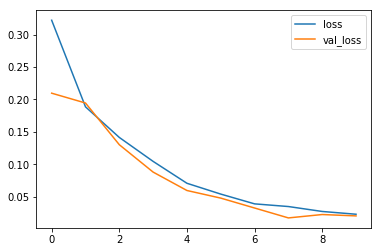

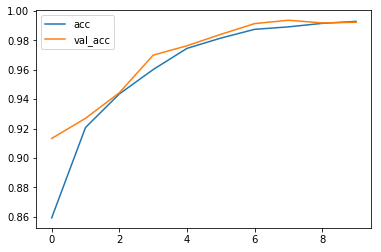

In [28]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

Confusion matrix:


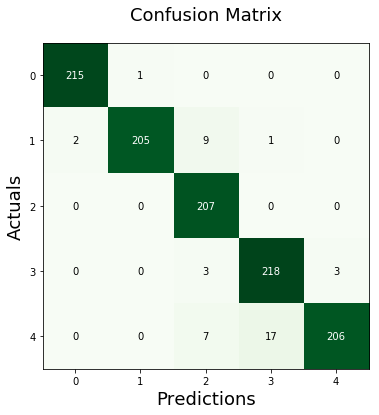

In [29]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_true, y_pred) 
print('Confusion matrix:')
 
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [30]:
accuracy = accuracy_score(y_true, y_pred) 
print('\nAccuracy : ', accuracy)


Accuracy :  0.9606946983546618


In [31]:
macro_precision = precision_score(y_true, y_pred, average = 'macro') 
micro_precision = precision_score(y_true, y_pred, average = 'micro') 
weighted_precision = precision_score(y_true, y_pred, average = 'weighted') 

print('Macro Precision : ', macro_precision)
print('Micro Precision : ', micro_precision)
print('Weighted Precision : ', weighted_precision)

Macro Precision :  0.9622465982639419
Micro Precision :  0.9606946983546618
Weighted Precision :  0.9626754867412635


In [32]:
macro_recall = recall_score(y_true, y_pred, average = 'macro') 
micro_recall = recall_score(y_true, y_pred, average = 'micro') 
weighted_recall = recall_score(y_true, y_pred, average = 'weighted') 

print('Macro recall : ', macro_recall)
print('Micro recall : ', micro_recall)
print('Weighted recall : ', weighted_recall)

Macro recall :  0.9617874581654385
Micro recall :  0.9606946983546618
Weighted recall :  0.9606946983546618


In [33]:
macro_f1 = f1_score(y_true, y_pred, average = 'macro') 
micro_f1 = f1_score(y_true, y_pred, average = 'micro') 
weighted_f1 = f1_score(y_true, y_pred, average = 'weighted') 

print('Macro f1 : ', macro_f1)
print('Micro f1 : ', micro_f1)
print('Weighted f1 : ', weighted_f1)

Macro f1 :  0.960956299098435
Micro f1 :  0.9606946983546618
Weighted f1 :  0.9606202469781007
